In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tom-and-jerry-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2136537%2F3682957%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T131914Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcdba625cab04f80e381cc44ea547936b6c9a26e6840c4876fcdb8114f3b034c502d70ee760db68600c69d50030fde774f60007a8b8ab769ff20d35fac3049ed0c6b2d23b2665bc95276a189836f1526c0ce84549b1f26809ebd3372b504ff1065c80b6ecca3293776435dc342234fb5096cb378670ef1b113a2d8c5885b5db312789e4a7be4f9fdd70007fd18a6b6914ee1a748c8f678ea6568ce171adcefcd68004aa97b883680a4c39b3cb63b45202df432b7f873d6a5dca498afde70490fe8d6bf4caa1dd8139dc9649b0743eb79bbaf81d767b5ce569211b3244e5ec0f203882fc61c973671ebc1144edf898392492415d3c561c68e62c928a8e039b780c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-04-08 09:45:44.408779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 09:45:44.408881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 09:45:44.607792: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
#Setting Constraints
IMAGE_DIRECTORY = "/kaggle/input/tom-and-jerry-image-classificationtom_and_jerry/tom_and_jerry/"
batch_size = 32
img_height = 72
img_width = 128


In [ ]:
#Loading the dataset and splitting into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIRECTORY,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5478 files belonging to 4 classes.
Using 4383 files for training.
Found 5478 files belonging to 4 classes.
Using 1095 files for validation.


In [ ]:
# Number of classes
num_classes = len(set(label for _, labels in train_ds for label in labels.numpy()))
print("Number of Classes:", num_classes)


Number of Classes: 4


In [ ]:
#Labeling categories
label_categories = {
    0: "Jerry",
    1: "Tom",
    2: "None",
    3: "Both"
}

In [ ]:
# CNN model architecture
cnn_model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


In [ ]:
# Compiling the model
cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
# Training the model
epochs = 10
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 29s 195ms/step - accuracy: 0.3613 - loss: 1.3594 - val_accuracy: 0.4995 - val_loss: 1.1221
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 0.5548 - loss: 1.0553 - val_accuracy: 0.6219 - val_loss: 0.9267
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - accuracy: 0.7030 - loss: 0.7843 - val_accuracy: 0.7406 - val_loss: 0.6918
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.8043 - loss: 0.5455 - val_accuracy: 0.7616 - val_loss: 0.6532
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.8495 - loss: 0.4095 - val_accuracy: 0.8146 - val_loss: 0.5918
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 0.8892 - loss: 0.3077 - val_accuracy: 0.7991 - val_loss: 0.5636
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 0.9050 - loss: 0.2476 - val_accuracy: 0.8265 - val_loss: 0.5574
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 41s 192ms/step - accuracy: 0.9275 - loss: 0

In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 72, 128, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 72, 128, 16)    │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 36, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,611,630 (13.78 MB)

 Trainable params: 1,203,876 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,407,754 (9.18 MB)

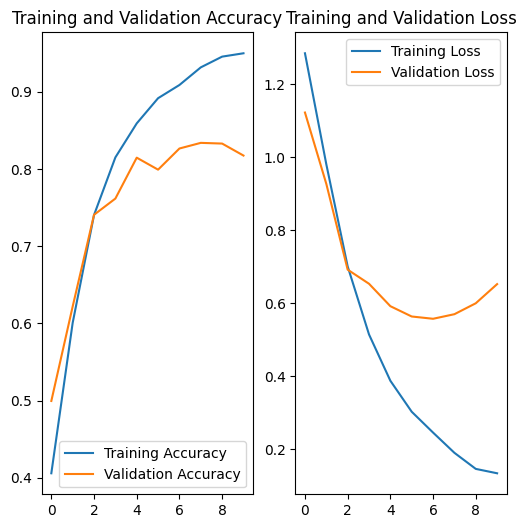

In [ ]:
# accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import csv

# Function to convert prediction to 0 or 1 for jerry and tom
def convert_to_binary(prediction):
    if 'jerry' in prediction:
        jerry = 1
        tom = 0
    if 'tom' in prediction:
        tom = 1
        jerry = 0
    if 'none' in prediction:
        tom = 0
        jerry = 0
    if 'both' in prediction:
        tom = 1
        jerry = 1
    else:
        tom = 0
    return jerry, tom

with open('predictions.csv', 'w', newline='') as csvfile:
    fieldnames = ['image_name', 'jerry', 'tom']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for prediction in predictions:
        jerry, tom = convert_to_binary(prediction['prediction'])
        writer.writerow({'image_name': prediction['image_name'], 'jerry': jerry, 'tom': tom})

print("CSV file created successfully.")


for i in val_ds:
    predictions = cnn_model.predict(images[i])

In [ ]:
import csv

# Define the CSV file name
csv_filename = "predictions.csv"

# Open the CSV file in write mode
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['image_name', 'jerry', 'tom'])

    # Iterate through the validation dataset and make predictions
    for images, labels in val_ds:
        # Predict the probabilities for each class
        predictions = cnn_model.predict(images)

        # Iterate through predictions for each image
        for i in range(len(images)):
            # Extract the image name from the dataset
            image_name = val_ds.file_paths[i].split('/')[-1]  # Adjust the splitting based on your file path

            # Determine whether 'jerry' or 'tom' has a higher probability
            jerry_probability = predictions[i][0]  # Probability for Jerry
            tom_probability = predictions[i][1]  # Probability for Tom

            # Assign 1 to the corresponding column and 0 to the other column
            jerry_value = 1 if jerry_probability > tom_probability else 0
            tom_value = 1 - jerry_value

            # Write the results to the CSV file
            writer.writerow([image_name, jerry_value, tom_value])

print("CSV file created successfully:", csv_filename)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━

In [ ]:
import csv

# Define the CSV file name
csv_filename = "predictions3.csv"

# Define the threshold for considering both classes present
threshold = 0.0  # Adjust this threshold as needed

# Open the CSV file in write mode
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['image_name', 'jerry', 'tom'])

    # Iterate through the validation dataset and make predictions
    for images, labels in val_ds:
        # Predict the probabilities for each class
        predictions = cnn_model.predict(images)

        # Iterate through predictions for each image
        for i in range(len(images)):
            # Extract the image name from the dataset
            image_name = val_ds.file_paths[i].split('/')[-1]  # Adjust the splitting based on your file path

            # Determine whether 'jerry' or 'tom' has a higher probability
            jerry_probability = predictions[i][0]  # Probability for Jerry
            tom_probability = predictions[i][1]  # Probability for Tom

            # Check if both classes have probabilities above the threshold
            if jerry_probability > threshold and tom_probability > threshold:
                jerry_value = 1
                tom_value = 1
            else:
                jerry_value = 0
                tom_value = 0

            # Write the results to the CSV file
            writer.writerow([image_name, jerry_value, tom_value])

print("CSV file created successfully:", csv_filename)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━